In [39]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

In [2]:
load_dotenv(override=True)

True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [4]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of India?")

'New Delhi is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat of all three branches of the Government ... New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River. Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the ... Delhi is a city and national capital territory in north-central India. The city of Delhi actually consists of two components: Old Delhi, in the north, ... If you are asked what the capital of India is, your answer will be New Delhi, which was settled by the British. Comments28. Geoff Dean. Is the territory of the capital New Delhi a part of India? OR like Washington D.C. and City of London ruled and owned

### Now here is a LangChain wrapper class for converting functions into Tools

In [5]:
from langchain.agents import Tool

tool_search = Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)

### Now we can try out the tool the langchain way

In [6]:
tool_search.invoke("What is the capital of India?")

'New Delhi is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat of all three branches of the Government ... New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River. Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the ... Delhi is a city and national capital territory in north-central India. The city of Delhi actually consists of two components: Old Delhi, in the north, ... Comments28. Geoff Dean. Is the territory of the capital New Delhi a part of India? OR like Washington D.C. and City of London ruled and owned by ... If you are asked what the capital of India is, your answer will be New Delhi, which was settled by the B

### And now let's write a tool ourselves

We'll pick a familiar one

In [7]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = os.getenv("PUSHOVER_URL")

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [8]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [51]:
tools = [tool_search, tool_push]

In [52]:
# Step 1: Define the State
# This is different from the BaseModel we've used before
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [53]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [54]:
# # This is different
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
# llm_with_tools = llm.bind_tools(tools)

In [55]:
# This is different
llm = ChatGroq(model=os.getenv("GROQ_MODEL_LLAMA3_3"))
llm_with_tools = llm.bind_tools(tools)

In [56]:
# Step 3: Create a Node

def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [57]:
# Step 4: Create Edges
# If statement if finish_reason=="tool_calls"
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

# Any time a tool is called, we return the chatbot to decide the next step
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")

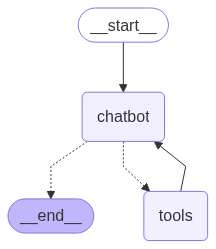

In [62]:
# Step 5: Complie the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [63]:
def invoke_graph(user_input:str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

gr.ChatInterface(invoke_graph, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [65]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

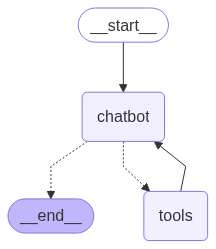

In [66]:
# Steps 1 Define State and 2 Start the Graph Builder with this State class
graph_builder = StateGraph(State)

# Step 3 create a Node
llm = ChatGroq(model=os.getenv("GROQ_MODEL_LLAMA3_3"))
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    print(f"state: {state}")
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4 Create Edges
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5 Compile the Graphs
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
config = {"configurable":{"thread_id":"1"}}

def chat(user_input:str, history):
    result = graph.invoke({"messages":[{"role":"user","content":user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


state: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='55693f13-82bf-437f-97dd-b3f897aa9b6f')]}
state: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='55693f13-82bf-437f-97dd-b3f897aa9b6f'), AIMessage(content='Hello, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 306, 'total_tokens': 316, 'completion_time': 0.036363636, 'prompt_time': 0.026972854, 'queue_time': 0.053551725999999994, 'total_time': 0.06333649}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'stop', 'logprobs': None}, id='run--938a56fe-2c09-4a80-9443-df28fe46d37b-0', usage_metadata={'input_tokens': 306, 'output_tokens': 10, 'total_tokens': 316}), HumanMessage(content='my name is anand', additional_kwargs={}, response_metadata={}, id='24d7144b-9e93-4ea8-952d-752997e37817')]}
state: {'messages': [HumanMessage(cont

In [68]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='55693f13-82bf-437f-97dd-b3f897aa9b6f'), AIMessage(content='Hello, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 306, 'total_tokens': 316, 'completion_time': 0.036363636, 'prompt_time': 0.026972854, 'queue_time': 0.053551725999999994, 'total_time': 0.06333649}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'stop', 'logprobs': None}, id='run--938a56fe-2c09-4a80-9443-df28fe46d37b-0', usage_metadata={'input_tokens': 306, 'output_tokens': 10, 'total_tokens': 316}), HumanMessage(content='my name is anand', additional_kwargs={}, response_metadata={}, id='24d7144b-9e93-4ea8-952d-752997e37817'), AIMessage(content="Hello Anand, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata

In [69]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='55693f13-82bf-437f-97dd-b3f897aa9b6f'), AIMessage(content='Hello, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 306, 'total_tokens': 316, 'completion_time': 0.036363636, 'prompt_time': 0.026972854, 'queue_time': 0.053551725999999994, 'total_time': 0.06333649}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'stop', 'logprobs': None}, id='run--938a56fe-2c09-4a80-9443-df28fe46d37b-0', usage_metadata={'input_tokens': 306, 'output_tokens': 10, 'total_tokens': 316}), HumanMessage(content='my name is anand', additional_kwargs={}, response_metadata={}, id='24d7144b-9e93-4ea8-952d-752997e37817'), AIMessage(content="Hello Anand, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadat

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [76]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path="memory.db"
connection = sqlite3.connect(db_path, check_same_thread=False)
sql_memory =  SqliteSaver(connection)

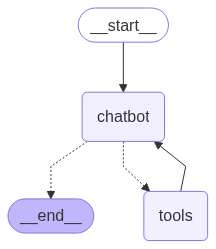

In [77]:
# Steps 1 Define State and 2 Start the Graph Builder with this State class
graph_builder = StateGraph(State)

# Step 3 create a Node
llm = ChatGroq(model=os.getenv("GROQ_MODEL_LLAMA3_3"))
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    print(f"state: {state}")
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4 Create Edges
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5 Compile the Graphs
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [78]:
config = {"configurable":{"thread_id":"2"}}

def chat(user_input:str, history):
    result = graph.invoke({"messages":[{"role":"user","content":user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


state: {'messages': [HumanMessage(content='Hi there', additional_kwargs={}, response_metadata={}, id='394b8309-c71c-4403-bd33-16b65cbfe5de'), AIMessage(content="I'm here to help. Is there something I can assist you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 307, 'total_tokens': 330, 'completion_time': 0.083636364, 'prompt_time': 0.023746971, 'queue_time': 0.178585099, 'total_time': 0.107383335}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--8ec808e7-4cf0-4ef0-8e3f-b1efe6d3d0e3-0', usage_metadata={'input_tokens': 307, 'output_tokens': 23, 'total_tokens': 330}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='aad4afa0-6d39-4f9f-a2a3-8dbd7176ee19'), AIMessage(content="I don't have any information about your name. I'm a text-based AI assistant, and our conversation just start